# Shor

In [1]:
import cirq
import numpy as np
import cirq_qubitization
import cirq_qubitization.testing as cq_testing
from cirq_qubitization.jupyter_tools import display_gate_and_compilation
from typing import *

## `ModMultiply`
ModMultiply(exponent_bitsize: int, x_bitsize: int, mul_constant: int, mod_N: int)

In [20]:
from cirq_qubitization.shor.mod_multiply import ModMultiply, LeftDangle, RightDangle, DanglingT, Split, Join
g = cq_testing.GateHelper(
    ModMultiply(exponent_bitsize=3, x_bitsize=3, mul_constant=123, mod_N=5)
)

display_gate_and_compilation(g)

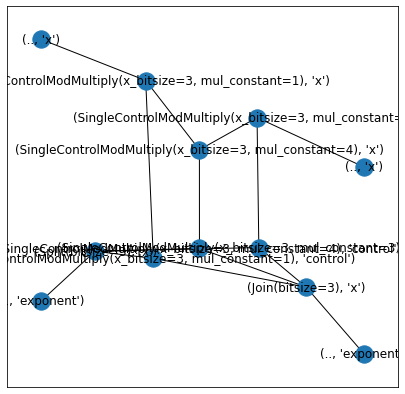

In [3]:
nodes, edges = g.gate.compute_graph()
import networkx as nx
from matplotlib import pyplot as plt

plt.subplots(figsize=(7,7))
gg = nx.from_edgelist(e.tt for e in edges)
rs = np.random.RandomState()
fuzz = lambda: rs.normal(0, 0.05)

pos = {}

for yi, r in enumerate(g.r):
    pos[LeftDangle, r.name] = (-1, 0.2*yi+fuzz())
    pos[RightDangle, r.name] = (len(nodes), 0.2*yi+fuzz())

for xi, gate in enumerate(nodes):
    
    for yi, r in enumerate(gate.registers):
        pos[gate, r.name] = (xi+fuzz(), 0.2*yi+fuzz())
    
    for r1, r2 in zip(gate.registers, gate.registers[1:]):
        gg.add_edge((gate, r1.name), (gate, r2.name), typ='vert')
    
    
#pos = nx.spring_layout(gg, pos=pos, iterations=1)
nx.draw_networkx(gg, pos=pos)

In [4]:
from collections import defaultdict
i_by_prefix = defaultdict(lambda: 0)
saved = {}

def gid(gate, regname):
    pot = saved.get((gate, regname), None)
    if pot is not None:
        return pot
    
    gname = gate.__class__.__name__
    i = i_by_prefix[gname, regname]
    i_by_prefix[gname, regname] += 1
    name = f'{gname}_{i}_{regname}'
    saved[gate, regname] = name
    return name



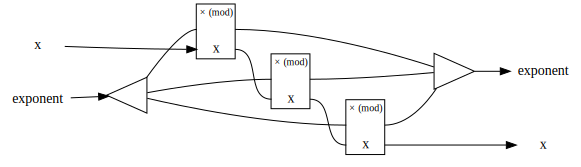

In [35]:
import networkx
import pydot

graph = pydot.Dot('qual', graph_type='digraph', rankdir='LR')




dang = pydot.Subgraph(rank='same')
for yi, r in enumerate(g.r):
    dang.add_node(pydot.Node(gid(LeftDangle, r.name), label=f'{r.name}', shape='plaintext'))
graph.add_subgraph(dang)
  
for xi, gate in enumerate(nodes):
    if isinstance(gate, Split):
        graph.add_node(pydot.Node(gid(gate, ''), shape='triangle', label='', orientation=90))
        continue
    if isinstance(gate, Join):
        graph.add_node(pydot.Node(gid(gate, ''), shape='triangle', label='', orientation=-90))
        continue
    
    
    ports = [f'<{r.name}>{r.name}' for r in gate.registers]
    label = '<<TABLE BORDER="1" CELLBORDER="0" CeLLSPACING="0">'
    label += f'<tr><td><font point-size="10">{gate.pretty_name()}</font></td></tr>'
    for r in gate.registers:
        if r.name == 'control':
            celllab='\u2b24'
        else:
            celllab=r.name
        
        label += f'<TR><TD PORT="{r.name}">{celllab}</TD></TR>'
    label += '</TABLE>>'
    
    #graph.add_node(pydot.Node(gid(gate, ''), label='|'.join([f'{gate.__class__.__name__}']+ports)))        
    graph.add_node(pydot.Node(gid(gate, ''), label=label, shape='plain'))

dang = pydot.Subgraph(rank='same')
for yi, r in enumerate(g.r):
    dang.add_node(pydot.Node(gid(RightDangle, r.name), label=f'{r.name}', shape='plaintext'))
graph.add_subgraph(dang)

for wire in edges:
    (lg, ln), (rg, rn) = wire.tt
    if isinstance(lg, DanglingT):
        graph.add_edge(pydot.Edge(gid(lg, ln), gid(rg, '')+':'+rn))
    elif isinstance(rg, DanglingT):
        graph.add_edge(pydot.Edge(gid(lg, '')+':'+ln, gid(rg, rn)))
    else:  
        graph.add_edge(pydot.Edge(gid(lg, '')+':'+ln, gid(rg, '')+':'+rn, arrowhead='none'))

from IPython.display import SVG
SVG(graph.create_svg())

In [30]:
print(graph.to_string())

graph qual {
rankdir=LR;
subgraph  {
rank=same;
DanglingT_0_exponent [label=exponent, shape=plaintext];
DanglingT_0_x [label=x, shape=plaintext];
}

Split_0_ [label="", orientation=90, shape=triangle];
SingleControlModMultiply_0_ [label=<<TABLE BORDER="1" CELLBORDER="0" CeLLSPACING="0"><tr><td><font point-size="10">× (mod)</font></td></tr><TR><TD PORT="control">⬤</TD></TR><TR><TD PORT="x">x</TD></TR></TABLE>>, shape=plain];
SingleControlModMultiply_1_ [label=<<TABLE BORDER="1" CELLBORDER="0" CeLLSPACING="0"><tr><td><font point-size="10">× (mod)</font></td></tr><TR><TD PORT="control">⬤</TD></TR><TR><TD PORT="x">x</TD></TR></TABLE>>, shape=plain];
SingleControlModMultiply_2_ [label=<<TABLE BORDER="1" CELLBORDER="0" CeLLSPACING="0"><tr><td><font point-size="10">× (mod)</font></td></tr><TR><TD PORT="control">⬤</TD></TR><TR><TD PORT="x">x</TD></TR></TABLE>>, shape=plain];
Join_0_ [label="", orientation=-90, shape=triangle];
subgraph  {
rank=same;
DanglingT_1_exponent [label=exponent, shape=

Split(bitsize=3) Register(name='x', bitsize=3)
SingleControlModMultiply(x_bitsize=3, mul_constant=1) Register(name='control', bitsize=1)
SingleControlModMultiply(x_bitsize=3, mul_constant=1) Register(name='x', bitsize=3)
SingleControlModMultiply(x_bitsize=3, mul_constant=4) Register(name='control', bitsize=1)
SingleControlModMultiply(x_bitsize=3, mul_constant=4) Register(name='x', bitsize=3)
SingleControlModMultiply(x_bitsize=3, mul_constant=3) Register(name='control', bitsize=1)
SingleControlModMultiply(x_bitsize=3, mul_constant=3) Register(name='x', bitsize=3)
Join(bitsize=3) Register(name='x', bitsize=3)


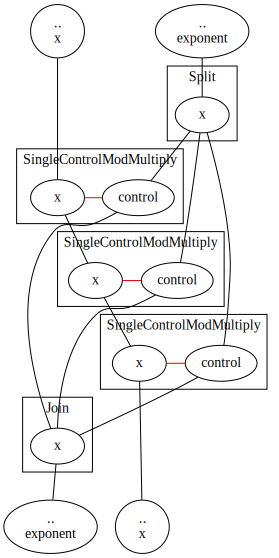

In [7]:
import networkx
import pydot

graph = pydot.Dot('qual', graph_type='graph', rankdir='TB')

for wire in edges:
    (lg, ln), (rg, rn) = wire.tt
    graph.add_edge(pydot.Edge(gid(lg, ln), gid(rg, rn)))


dang = pydot.Subgraph(rank='same')
for yi, r in enumerate(g.r):
    dang.add_node(pydot.Node(gid(LeftDangle, r.name), label=f'{LeftDangle}\n{r.name}'))
    #graph.add_node(pydot.Node(gid(RightDangle, r.name), label=f'{RightDangle}\n{r.name}'))
graph.add_subgraph(dang)

    
for xi, gate in enumerate(nodes):    
    
    clu = pydot.Cluster(graph_name=gid(gate, 'cluster'), label=f'{gate.__class__.__name__}')
    #clu = pydot.Subgraph()
    
    for yi, r in enumerate(gate.registers):
        print(gate, r)
        clu.add_node(pydot.Node(gid(gate, r.name), label=f'{r.name}'))
        
    for r1, r2 in zip(gate.registers, gate.registers[1:]):
        clu.add_edge(pydot.Edge(gid(gate, r1.name), gid(gate, r2.name), color='red', constraint=False))
    
    #clu0.add_subgraph(clu)
    graph.add_subgraph(clu)



dang = pydot.Subgraph(rank='same')
for yi, r in enumerate(g.r):
    #graph.add_node(pydot.Node(gid(LeftDangle, r.name), label=f'{LeftDangle}\n{r.name}'))
    dang.add_node(pydot.Node(gid(RightDangle, r.name), label=f'{RightDangle}\n{r.name}'))
graph.add_subgraph(dang)



from IPython.display import SVG
SVG(graph.create_svg())

In [8]:
print(graph.to_string())

graph qual {
rankdir=TB;
DanglingT_0_exponent -- Split_0_x;
Split_0_x -- SingleControlModMultiply_0_control;
SingleControlModMultiply_0_control -- Join_0_x;
DanglingT_0_x -- SingleControlModMultiply_0_x;
Split_0_x -- SingleControlModMultiply_1_control;
SingleControlModMultiply_1_control -- Join_0_x;
SingleControlModMultiply_0_x -- SingleControlModMultiply_1_x;
Split_0_x -- SingleControlModMultiply_2_control;
SingleControlModMultiply_2_control -- Join_0_x;
SingleControlModMultiply_1_x -- SingleControlModMultiply_2_x;
SingleControlModMultiply_2_x -- DanglingT_1_x;
Join_0_x -- DanglingT_1_exponent;
subgraph  {
rank=same;
DanglingT_0_exponent [label="..\nexponent"];
DanglingT_0_x [label="..\nx"];
}

subgraph cluster_Split_0_cluster {
label=Split;
Split_0_x [label=x];
}

subgraph cluster_SingleControlModMultiply_0_cluster {
label=SingleControlModMultiply;
SingleControlModMultiply_0_control [label=control];
SingleControlModMultiply_0_x [label=x];
SingleControlModMultiply_0_control -- SingleC

In [9]:
print(graph.create_dot().decode())

graph qual {
	graph [bb="0,0,271.67,550.48",
		rankdir=TB
	];
	node [label="\N"];
	{
		graph [rank=same];
		DanglingT_0_exponent	[height=0.74639,
			label="..\nexponent",
			pos="198.67,523.61",
			width=1.2964];
		DanglingT_0_x	[height=0.74639,
			label="..\nx",
			pos="53.669,523.61",
			width=0.75];
	}
	{
		graph [rank=same];
		DanglingT_1_x	[height=0.74639,
			label="..\nx",
			pos="138.67,26.87",
			width=0.75];
		DanglingT_1_exponent	[height=0.74639,
			label="..\nexponent",
			pos="46.669,26.87",
			width=1.2964];
	}
	subgraph cluster_SingleControlModMultiply_0_cluster {
		graph [bb="12.669,330.74,179.67,405.74",
			label=SingleControlModMultiply,
			lheight=0.21,
			lp="96.169,394.24",
			lwidth=2.10
		];
		SingleControlModMultiply_0_control	[height=0.5,
			label=control,
			pos="134.67,356.74",
			width=0.99297];
		SingleControlModMultiply_0_x	[height=0.5,
			label=x,
			pos="53.669,356.74",
			width=0.75];
		SingleControlModMultiply_0_control -- SingleControlModMultiply_0_x	[

In [10]:
n = graph.get_node_list()[0] 
n.get_name()

IndexError: list index out of range

In [ ]:
import graphviz
>>> dot = graphviz.Digraph(comment='The Round Table')
>>> dot.node('A', 'King Arthur')  # doctest: +NO_EXE
>>> dot.node('B', 'Sir Bedevere the Wise')
>>> dot.node('L', 'Sir Lancelot the Brave')

>>> dot.edges(['AB', 'AL'])
>>> dot.edge('B', 'L', constraint='false')

In [ ]:
nodes

In [ ]:
nodes[0].registers

In [ ]:
list(gg.nodes)

## `SingleControlModMultiply`
SingleControlModMultiply(x_bitsize: int, mul_constant: int)

In [ ]:
from cirq_qubitization.shor.mod_multiply import SingleControlModMultiply
g = cq_testing.GateHelper(
    SingleControlModMultiply(x_bitsize=3, mul_constant=123)
)

display_gate_and_compilation(g)